# What is this notebook used for ?

The purpose of this notebook is to create a **Multi Layers Perceptron (MLP)** to test this model on the binary classification task (find if a character belong to the horde/alliance) on images with background.

CNNs are mainly used in image classification, but starting this project with MLP models makes it possible to manipulate general Deep Learning techniques and to be able to compare a more complex model than the "baseline_estimator".



# How is it done?

I use keras and theoretical knowledge to test and improve MLP models. This notebook does not present all the exploratory steps but summarizes this approach.

Enjoy it ! :)

**Useful sources :**
- MIT Introduction to Deep Learning | 6.S191 : 
https://www.youtube.com/watch?v=njKP3FqW3Sk&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&ab_channel=AlexanderAmini
- MLP's web page on Wikipedia : https://en.wikipedia.org/wiki/Multilayer_perceptron
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition : https://www.amazon.fr/Hands-Machine-Learning-Scikit-learn-Tensorflow/dp/1492032646

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

# Create image loader using Keras

ImageDataGenerator documentation : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Good tutorial : https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

In [10]:
# data generator
datagen = ImageDataGenerator()

In [11]:
def load_images_set(directory, batch_size=32, format_="jpg", seed=0):
    """
    This function creates an image loader using flow_from_directory method
    of an ImageDataGenerator instance.
    
    Parameters
    ----------
    directory : string
                directory where images are stored
    batch_size : int, default=32
                size of the batch to create                
    format_ : string
              image format              
    seed : int
           seed for the reproductibility            
                
    Returns
    -------
    dataset : string
              A DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a 
              batch of images with shape (batch_size, *target_size, channels) and y is a numpy array 
              of corresponding labels.    
    """
    dataset = datagen.flow_from_directory(directory, class_mode='binary', batch_size=batch_size, 
                                        save_format=format_, seed=seed)
    return dataset
# data directories
directory_train = "Data/With_background/train"
directory_validation = "Data/With_background/validation"

train_it = load_images_set(directory_train)
validation_it = load_images_set(directory_validation)

Found 25126 images belonging to 2 classes.
Found 6283 images belonging to 2 classes.


Don't forget the argument class_mode="binary" for our binary classification task.

By default **flow_from_directory resizes images to (256, 256)**. We will leave the default parameter but it is important to note this step to understand the shape of the data we will have to give to the network a little below.

An other important point is that by default we load images in RGB (in color).

In [4]:
# label format
labels = train_it.class_indices
print(labels)

{'alliance': 0, 'horde': 1}


In [12]:
def index_to_label(int_class):
    """
    Returns the label associated with the index.
    
    Parameters
    ----------
    int_class : int
                index of an image
    Returns
    -------
    label : string
            the label associated with this index
    
    Examples
    -------
    >>> index_to_label(0)
        "alliance"
    >>> index_to_label(1)
        "horde"

    """
    # test if the argument is
    if int_class not in labels.values():
        print("Argument must be 0 or 1.")
    else:
        # iter on dictionary values 
        for label, index in labels.items():
            # return the label associate to index
            if int_class == index:
                return label

In [6]:
# Example for the first batch
batchX, batchy = train_it[0]

print("Labels examples :\n", batchy, end="\n\n")
print("images batch shape:", batchX.shape, end="\n\n")
print("label's shape:", batchy.shape)
print("Min : ", batchX.min() , "Max : ", batchX.max(), "\nMean : ", batchX.mean(), "std : ", batchX.std())

Labels examples :
 [1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 0.]

images batch shape: (32, 256, 256, 3)

label's shape: (32,)
Min :  0.0 Max :  255.0 
Mean :  41.54169 std :  38.03526


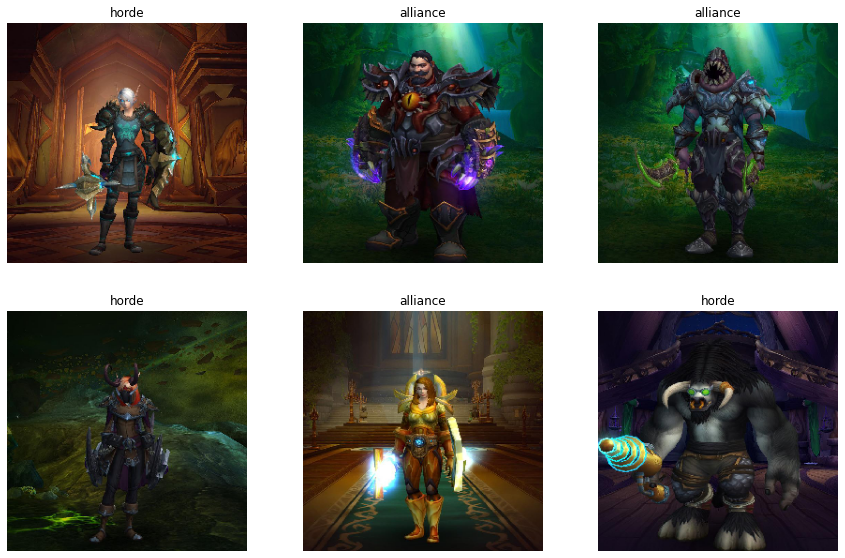

In [7]:
# Example of images in the first batch with their associated labels
plt.figure(figsize=(15, 15))

for i in range(6):
    # take the image and associated index
    image, label = batchX[i], batchy[i]
    # places the image correctly in the subplot
    ax = plt.subplot(3, 3, i + 1)
    # transforms the image into a visible format
    plt.imshow(image.astype("uint8"))
    # recover the label with index
    class_name = index_to_label(label)
    # put the label above the image
    plt.title(class_name)
    # don't display axis
    plt.axis("off")

# Images normalization

Standardisation is very important, especially with the architecture we are going to use below! 

We need :
- mean=0
- std=1.

So we'll use the classic standardization : $\frac{x - \mu}{\sigma}$.

The main problem here is that the dataset doesn't hold in memory, so in order to get the mean and standard deviation I will calculate them manually below.

In [22]:
# Image shape's
img_shape = (256, 256, 3)
# Total number of images in the training set
images_nb = train_it.samples
# Add 1 in order to have all the data
nb_batch = int(train_it.samples / batch_size) + 1

print("Number of images : ", images_nb)
print("Number of batch : ", images_nb / batch_size)
print(nb_batch)

Number of images :  25126
Number of batch :  785.1875
786


## Image mean

In order to be able to center images it is necessary to retrieve the average image over the whole learning set.

$\mu = \frac{1}{n}\left (\sum_{i=1}^n{x_i}\right ) = \frac{x_1+x_2+\cdots +x_n}{n}$

Where $x_i$ are matrix with shape (256, 256, 3) and n the number of images in the training set in our case.

In [10]:
# Creation of a matrix of the same size as the images with only 0's
sum_image = np.zeros(shape=img_shape)

# for each batch
for i in tqdm(range(nb_batch)):
    # load images and labels 
    batchX, batchy = train_it[i]
    # compute the sum of all images in this batch
    batch_sum = np.mean(batchX, axis=0)
    # add the sum to the matrix above created
    sum_image += batch_sum

# Divides the sum of the images by the number of images as in the above equation
image_mean = sum_image / images_nb

## Images variance

The variance of a collection of <math>n</math> equally likely values can be written as

$ \sigma^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2 = \left( \frac{1}{n} \sum_{i=1}^n x_i^2 \right) - \mu^2$

https://en.wikipedia.org/wiki/Variance

In our case $x_i$ is a matrix with shape (256, 256, 3) and $\mu$ is the average image calculated above, and n is the total number of images.

$ \sigma$ is call **standard deviation** and we need this quantity for the normalization.

We can compute this quantity with a simple for loop.

In [23]:
# Creation of a matrix of the same size as the images with only 0's
var_images = np.zeros(shape=img_shape)

# for each batch
for i in tqdm(range(nb_batch)):
    # load images and labels 
    batchX, batchy = train_it[i]
    
    # this number is equal to 32 for each batch except the last
    nb_images = batchX.shape[0]
    # for each image in the batch
    for j in range(nb_images):
        # calculate the sum of the above equation
        deviation_from_average_image = (batchX[j] - image_mean)**2
        # add the sum to the matrix above created
        var_images += deviation_from_average_image
        
# Divides the sum by the number of images as in the above equation
var_images /=  images_nb

In [24]:
# Standard deviation recovery
std_images = np.sqrt(var_images)

In [8]:
# store the 2 matrix into a dictionnary
dico_normalization = {"mean": image_mean,
                     "std": std_images}

# Store the informations in a pickle file
with open('Data/pickle/normalization_matrix.pkl', 'wb') as save_file:
    pickle.dump(dico_normalization, save_file, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'image_mean' is not defined

# Multi layers perceptron model

In this notebook, the architecture that will be implemented is a Dense layer sequential architecture. 

Such an architecture can take advantage of particularly interesting features (auto-normalization of the layers between them which avoids disappearances or gradient explosions) under certain conditions (selu activation function, weight's initialization of "lecun_normal" & input data with mean=0 // std=1).

More informations here : 
- Original article : https://arxiv.org/abs/1706.02515
- **Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition** by Aurélien Géron.

In [13]:
# Important for reproductibility
tf.random.set_seed(42)
np.random.seed(42)

In [15]:
# Load normalization images previously stored 
with open("Data/pickle/normalization_matrix.pkl", "rb") as file:
    dico_normalization = pickle.load(file)

mean = dico_normalization["mean"]
std = dico_normalization["std"]

# Creation of a layer that normalizes images before putting them into the network
normalization_layer = tf.keras.layers.Lambda(lambda x: (x-mean)/std)

In [16]:
def build_model(n_layer=3, n_neurons=100, input_shape=(256, 256, 3), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                activation_dense="relu", init_weights="lecun_normal"):
    """
    Creates a sequential multi layer perceptron model with the same number of neurons by layer.
    
    Args:
        n_layer (int): number of layer
        n_neurons (int): number of neurons by layer
        input_shape (tuple): input shape (image size)
        optimizer (tf.keras.optimizers): model's optimizer
        activation_dense (str): dense's layer activation function
        init_weights (str): weights' initialization
        
    Returns:
        model (tensorflow.keras.models.Sequential): built model 
    """
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(normalization_layer)
    model.add(layers.Flatten())
    # Add dense layers
    for i in range(n_layer):
        model.add(layers.Dense(n_neurons, activation=activation_dense, 
                               kernel_initializer=init_weights)) 
    # Add output layer : sigmoid for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model  

More informations about early stopping : https://en.wikipedia.org/wiki/Early_stopping

In [231]:
# The code from this cell is from :
# https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb (cell 83)
import os
import time

root_logdir = os.path.join(os.curdir, "Models")

def get_run_logdir(model_name):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join("Models",  run_id + model_name)
    

run_logdir = get_run_logdir("_PMC_classifier.h5")

## Callbacks

Documentation : https://keras.io/api/callbacks/

In [30]:
# early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# checkpoint_model
checkpoint_model_cb = keras.callbacks.ModelCheckpoint(run_logdir)

## Build model

In [33]:
model = build_model(n_layer=3,n_neurons=100, activation_dense="selu",
                   optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-6),
                   init_weights="lecun_normal")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               19660900  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 19,681,201
Trainable params: 19,681,201
Non-trainable params: 0
__________________________________________

## Training

In [34]:
epochs = 50
history = model.fit (train_it, 
                     verbose=1,
                     epochs=epochs,
                     validation_data=validation_it,
                    callbacks=[early_stopping_cb, checkpoint_model_cb])

Epoch 1/50
786/786 [==============================] - 331s 421ms/step - loss: 0.5523 - accuracy: 0.8125 - val_loss: 0.5018 - val_accuracy: 0.9117
Epoch 2/50
786/786 [==============================] - 234s 298ms/step - loss: 0.5027 - accuracy: 0.9134 - val_loss: 0.4822 - val_accuracy: 0.9355
Epoch 3/50
786/786 [==============================] - 228s 290ms/step - loss: 0.4891 - accuracy: 0.9367 - val_loss: 0.4747 - val_accuracy: 0.9478
Epoch 4/50
786/786 [==============================] - 228s 290ms/step - loss: 0.4829 - accuracy: 0.9445 - val_loss: 0.4787 - val_accuracy: 0.9249
Epoch 5/50
786/786 [==============================] - 227s 289ms/step - loss: 0.4777 - accuracy: 0.9529 - val_loss: 0.4676 - val_accuracy: 0.9605
Epoch 6/50
786/786 [==============================] - 226s 288ms/step - loss: 0.4746 - accuracy: 0.9584 - val_loss: 0.4658 - val_accuracy: 0.9629
Epoch 7/50
786/786 [==============================] - 227s 289ms/step - loss: 0.4721 - accuracy: 0.9617 - val_loss: 0.4661 -

## Training curves

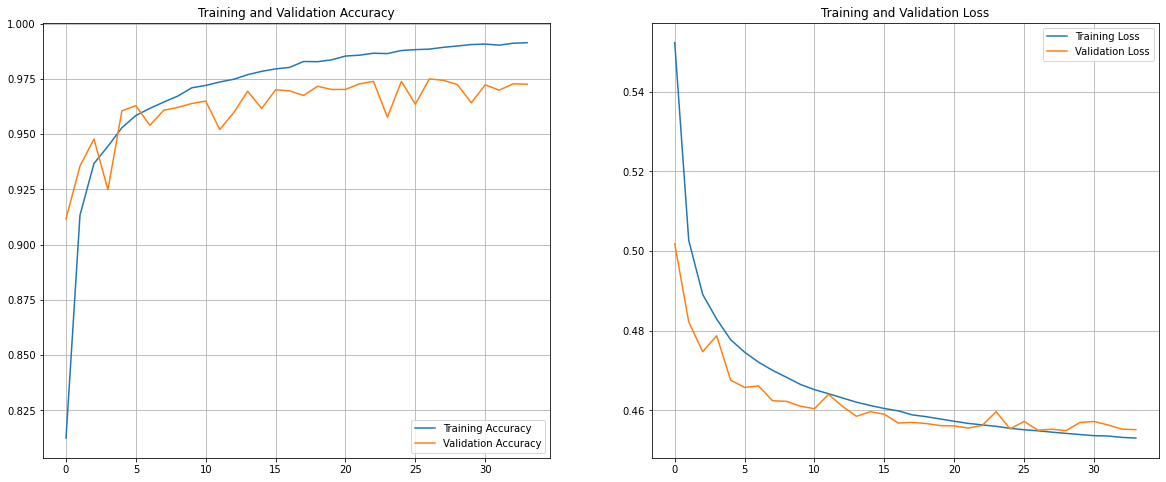

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

We can clearly see on en validation's graph that the model is overfitting : training accurary continues to increase while validation no longer increases.

A similar behaviour is observed on the loss graph, the training loss decreases while the validation loss no longer decreases in the last iterations.

# Test MLP models on the test set 

**Note:** the model could (and should) have been re-trained on the training + validation set but this was not done to save time (the MLP model training time is long).

In [17]:
directory_test = "Data/With_background/test"
# load and iterate test dataset // seed for reproductibility
test_it = load_images_set(directory_test)

Found 13461 images belonging to 2 classes.


In [18]:
# Load model
model = keras.models.load_model('Models\\run_2020_12_17-18_21_13_PMC_classifier.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               19660900  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 19,681,201
Trainable params: 19,681,201
Non-trainable params: 0
__________________________________________

In [163]:
loss_test, accuracy_test = model.evaluate(test_it)

print("Loss on the test set :", loss_test, 
     "\nAccuracy on the test set : ", accuracy_test)

421/421 [==============================] - 100s 237ms/step - loss: 0.4624 - accuracy: 0.9695
Loss on the test set : 0.4623750150203705 
Accuracy on the test set :  0.9694673418998718


**This performance seems good and close to what was identified in the baseline script.**

Let's look at some examples of predictions with associated probabilities!

## Examples of model predictions

There is only one **ouput neuron that returns a probability** of belonging to the positive class (which in our case is the horde).

There is a need for quick post processing in order to obtain the label corresponding to an image.

More informations here : https://en.wikipedia.org/wiki/Sigmoid_function

In [18]:
def from_proba_positive_to_label(proba):
    """
    Takes a probability & returns associated faction.
    
    Args:
        proba (float): the probability of belonging to the horde
        
    Returns:
        label (str): the faction
    """
    if proba < 0.5:
        label = "alliance"
    else:
        label = "horde"
    return label

# vectorize the function
from_proba_positive_to_label = np.vectorize(from_proba_positive_to_label)

In [28]:
index_to_label = np.vectorize(index_to_label)

def _transform_outputs(batch_number):
    """
    Takes a batch number & returns associated positive probability, predicted labels & true labels.
    
    Args:
        batch_number (int): the number of the number
    
    Returns:
        y_pred_proba_positive (np.array): probabilities by batch's images
        y_pred (np.array): predicted faction
        y_test (np.array): true faction
    """
    # first batch
    batchX_test, batchy_test = test_it[batch_number]
    # probability prediction for each image in this batch
    y_pred_proba_positive = model.predict(batchX_test)

    # Use above function to recover the labels
    y_pred = from_proba_positive_to_label(y_pred_proba_positive)
    # Transform the index into labels
    y_test = index_to_label(batchy_test)

    print("Prediction : ", y_pred[0][0])
    print("True label : ", y_test[0])
    return y_pred_proba_positive, y_pred, y_test

# calculates these quantities for the 1st batch
y_pred_proba_positive, y_pred, y_test = _transform_outputs(0)

Prediction :  alliance
True label :  alliance


### Good predictions

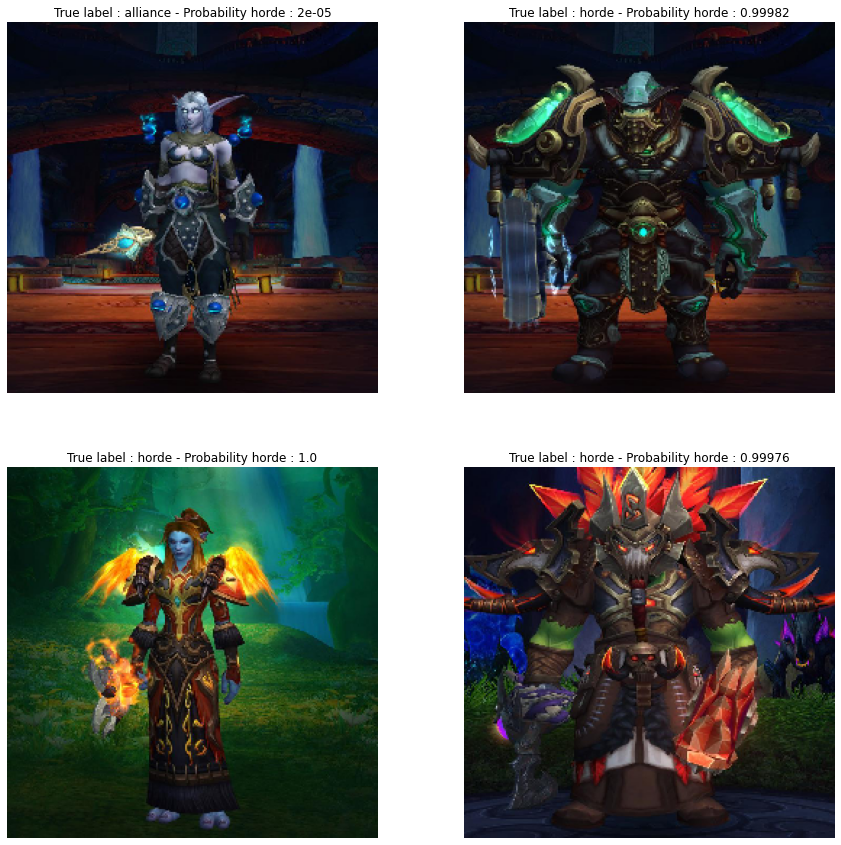

In [31]:
# Examples !
batchX_test, batchy_test = test_it[0]

plt.figure(figsize=(15, 15))

for i in range(4):
    # images, true label & model's prediction
    image, true_label, prediction = batchX_test[i], y_test[i], str(y_pred[i][0])
    # probability of belonging to the horde
    proba_h2 = str(round(y_pred_proba_positive[i][0], 5))
    # plot the images
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title("True label : " + true_label + " - Probability horde : " + proba_h2)
    plt.axis("off")

### Where did the model go wrong?

In order to better understand the errors in the model it is necessary to analyse where the errors were made.

Let's do this !

In [34]:
def return_images_prob(list_batch_number):
    """
    Records the images that had a prediction problem with the corresponding information.
    
    Args:
        list_batch_number (list): the list of batches in which we will look for prediction errors in the test set
        
    Returns:
        dico_images_prob (dict): dictionary containing error information
    """
    dico_images_prob = {}
    list_col = ["image", "probability", "true_label", "prediction"]
    
    for col in list_col:
        dico_images_prob[col] = []

    for number in list_batch_number:
        batchX_test, batchy_test = test_it[number]

        y_pred_proba_positive = model.predict(batchX_test)
        y_pred = from_proba_positive_to_label(y_pred_proba_positive)
        y_test = index_to_label(batchy_test)

        mask_prob = y_test != y_pred.ravel()
        index_prob = list(np.where(mask_prob)[0])

        if len(index_prob) >= 1:
            for index in index_prob:
                dico_images_prob["image"].append(batchX_test[index])
                dico_images_prob["probability"].append(y_pred_proba_positive[index])
                dico_images_prob["true_label"].append(y_test[index])
                dico_images_prob["prediction"].append(y_pred[index])
    return dico_images_prob

dico_images_wrong = return_images_prob(list(range(20)))
print("Number of images with a wrong prediction in this dictionnary : ", len(dico_images_wrong["image"]))

Number of images with a wrong prediction in this dictionnary :  17


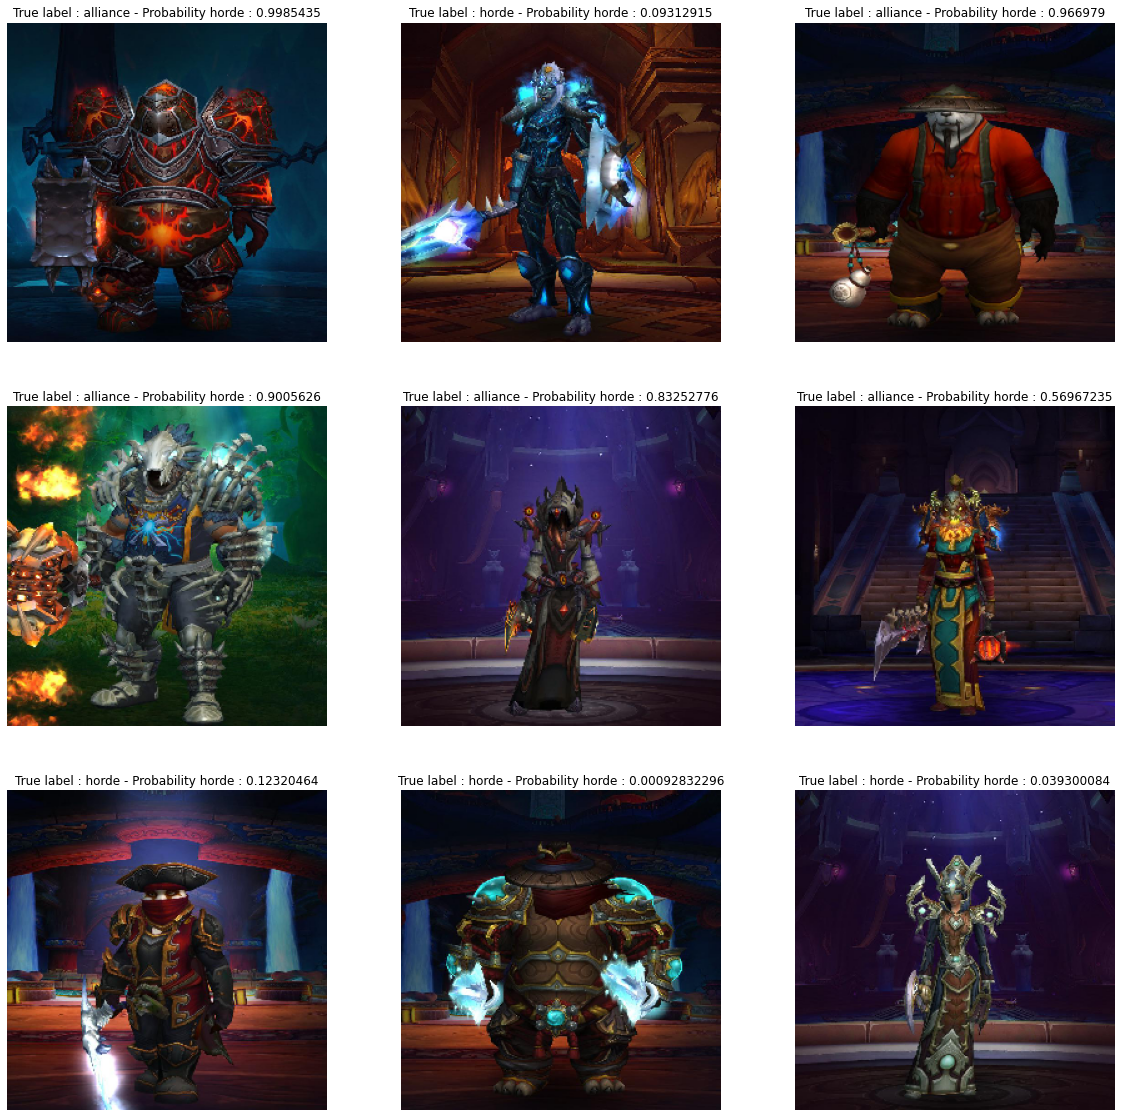

In [35]:
# Example of images in the first batch with their associated labels
plt.figure(figsize=(20, 20))

for i in range(9):
    # take the image and associated index
    image, label = dico_images_wrong["image"][i], str(dico_images_wrong["true_label"][i])
    proba_h2 = str(dico_images_wrong["probability"][i][0])
    # places the image correctly in the subplot
    ax = plt.subplot(3, 3, i + 1)
    # transforms the image into a visible format
    plt.imshow(image.astype("uint8"))
    # recover the label with index
    # put the label above the image
    plt.title("True label : " + label + " - Probability horde : " + proba_h2)
    # don't display axis
    plt.axis("off")

# Conclusion

We can see that the model is wrong on cases that we cannot identify even as a human knowing the game (example: first row). However, it can be seen that the model has made some mistakes (bottom left and bottom right images) that can be correctly identified by a human.

**An improvement in performance is therefore possible!**

Apart from that, although the MLP model is based on simple operations, it is computationally very expensive and requires a lot of parameters without learning any patterns in these images.

The objective for the continuation of this work is therefore : 
- to make a model with better performance
- to make a model with fewer parameters and being lighter.

**Let's test the use of CNNs and transfer of learning!**